## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras.

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**.

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [1]:
from importlib import resources
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

In [2]:
# Estilo
plt.style.use('dark_background')

In [3]:
# Fecha de análisis
fecha_analisis = pd.to_datetime('2025-10-01')

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

Haz un primer análisis visual de la información que tenemos del universo de bono.
Entre otras, plantéate cuestiones como:
- ¿Divisas?
- ¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?
- ¿Sectores? ¿Emisores? Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?
- ¿Ratings? (Riesgo de crédito)
- ¿Otros datos cuantitativos?
    - Riesgo de liquidez - Horquillas y nominal vivo
- ¿Hay *gaps* en la información que vamos a tener que tratar?

In [4]:
from pathlib import Path
# Ruta relativa desde src/ hacia data/ (un nivel arriba)
# Si el notebook se ejecuta desde src/, esta ruta funcionará
data_path = Path('../data/universo.csv')
universo = pd.read_csv(data_path, sep=';', encoding='utf-8-sig')

#### <font color=#808080>Divisas</font>

In [5]:
print("ANÁLISIS DE DIVISAS:")
currency = universo['Ccy'].value_counts(dropna = False) 
for curr, quantity in currency.items():
    print(f"  - {curr}: {quantity} bonos")

ANÁLISIS DE DIVISAS:
  - EUR: 2255 bonos


**Conclusión**: Todos los bonos están denominados en EUR. Esto elimina el riesgo por cambio de divisas.

 TIPOS DE BONOS:
Tipo de Cupón:
  - FIXED: 1910 bonos
  - VARIABLE: 345 bonos
Prelación (Seniority):
  - Sr Unsecured: 1675 bonos
  - Sr Non Preferred: 190 bonos
  - Sr Preferred: 179 bonos
  - Subordinated: 153 bonos
  - Jr Subordinated: 25 bonos
  - Secured: 20 bonos
  - 1st lien: 13 bonos
Optionalidad (Callable):
  - Y: 1640 bonos
  - N: 615 bonos
-> 72.7% de los bonos son callable
Frecuencia de Cupón:
  - 1 pago(s) por año: 2245 bonos
  - 2 pago(s) por año: 10 bonos
Bonos perpetuos o no (Maturity):
  - Bonos con fecha de vencimiento: 2236
  - Bonos perpetuos (sin fecha): 19
Para valorar los bonos perpetuos hay que tener en cuenta que la fecha de vencimiento es la de la primera call.


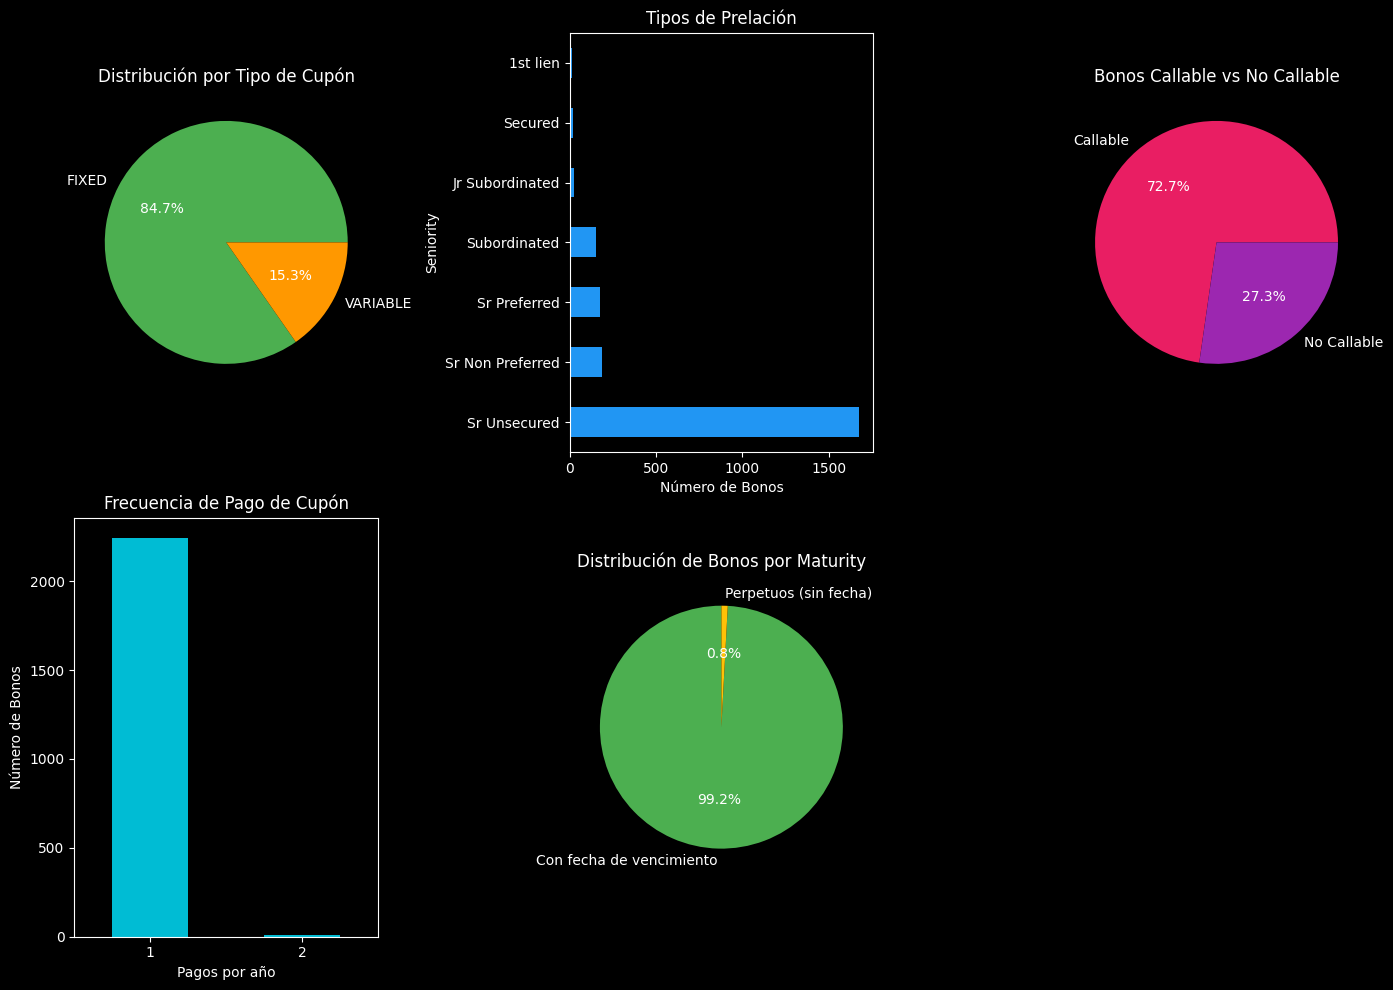

In [6]:
# Análisis de tipos de bonos
print(" TIPOS DE BONOS:")

# Tipo de cupón
print("Tipo de Cupón:")
coupon_types = universo['Coupon Type'].value_counts(dropna = False) 
for coupon, quantity in coupon_types.items():
    print(f"  - {coupon}: {quantity} bonos")

# Visualización
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

# Gráfico 1: Tipo de cupón
coupon_types.plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%', colors=['#4CAF50', '#FF9800'])
axes[0,0].set_title('Distribución por Tipo de Cupón')
axes[0,0].set_ylabel('')

# Prelación
print("Prelación (Seniority):")
seniority = universo['Seniority'].value_counts(dropna = False) 
for senior, quantity in seniority.items():
    print(f"  - {senior}: {quantity} bonos")

# Gráfico 2: Prelación
seniority.plot(kind='barh', ax=axes[0,1], color='#2196F3')
axes[0,1].set_title('Tipos de Prelación')
axes[0,1].set_xlabel('Número de Bonos')

# Callable
print("Optionalidad (Callable):")
callable_analysis = universo['Callable'].value_counts(dropna = False) 

for call , quantity in callable_analysis.items():
    print(f"  - {call}: {quantity} bonos")

callable_pct = callable_analysis.get('Y', 0)/len(universo)*100
print(f"-> {callable_pct:.1f}% de los bonos son callable")

# Gráfico 3: Callable
callable_analysis.plot(kind='pie', ax=axes[0,2], autopct='%1.1f%%',
                       colors=['#E91E63', '#9C27B0'],
                       labels=['Callable', 'No Callable'])
axes[0,2].set_title('Bonos Callable vs No Callable')
axes[0,2].set_ylabel('')

# Frecuencia de cupón
print("Frecuencia de Cupón:")
freq = universo['Coupon Frequency'].value_counts(dropna = False) 
for frequency, quantity in freq.items(): #Cambio el print para que muestre la información más clara
    print(f"  - {frequency} pago(s) por año: {quantity} bonos")

# Gráfico 4: Frecuencia
freq.plot(kind='bar', ax=axes[1,0], color='#00BCD4')
axes[1,0].set_title('Frecuencia de Pago de Cupón')
axes[1,0].set_xlabel('Pagos por año')
axes[1,0].set_ylabel('Número de Bonos')
axes[1,0].tick_params(axis='x', rotation=0)


# Maturity:
print("Bonos perpetuos o no (Maturity):")

maturity_date = universo[universo['Maturity'].notna() & (universo['Maturity'] != '')]
no_maturity_date= universo[universo['Maturity'].isna() | (universo['Maturity'] == '')]

print(f"  - Bonos con fecha de vencimiento: {len(maturity_date)}")
print(f"  - Bonos perpetuos (sin fecha): {len(no_maturity_date)}")

print("Para valorar los bonos perpetuos hay que tener en cuenta que la fecha de vencimiento es la de la primera call.")

# Gráfico 4: Maturity
labels = ['Con fecha de vencimiento', 'Perpetuos (sin fecha)']
sizes = [len(maturity_date), len(no_maturity_date)]
colors = ['#4CAF50', '#FFC107']

axes[1,1].pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Distribución de Bonos por Maturity')

# Ocultar el grafico vacio
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

#### <font color=#808080>Sectores y emisores</font>

ANÁLISIS DE SECTORES Y EMISORES:
Distribución por Sectores:
  - Financial : 1012 bonos
  - Consumer, Non-cyclical : 400 bonos
  - Industrial : 211 bonos
  - Communications : 175 bonos
  - Consumer, Cyclical : 171 bonos
  - Utilities : 150 bonos
  - Basic Materials : 72 bonos
  - Technology : 51 bonos
  - Energy : 13 bonos
Total de sectores únicos: 9
Total de emisores únicos: 613
Top 10 Emisores:
  - BANQUE FED CRED MUTUEL: 33 bonos
  - BNP PARIBAS: 27 bonos
  - VONOVIA SE: 23 bonos
  - BPCE SA: 23 bonos
  - ORANGE SA: 23 bonos
  - SOCIETE GENERALE: 21 bonos
  - VOLKSWAGEN INTL FIN NV: 21 bonos
  - NESTLE FINANCE INTL LTD: 20 bonos
  - CREDIT AGRICOLE SA: 19 bonos
  - UNIBAIL-RODAMCO-WESTFLD: 19 bonos
Análisis de Concentración:
  - Top 5 emisores: 5.7% del universo
  - Top 5 sectores: 87.3% del universo


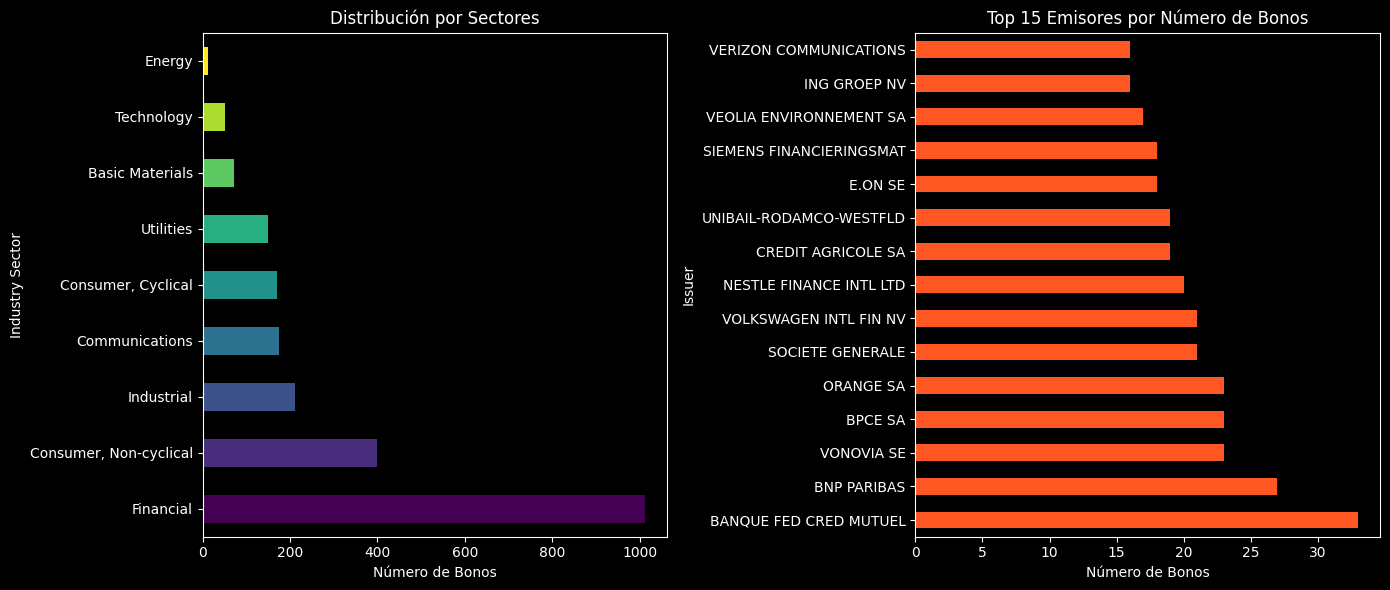

In [7]:
# Análisis de sectores y emisores
print("ANÁLISIS DE SECTORES Y EMISORES:")


# Sectores
sector_counts = universo['Industry Sector'].value_counts(dropna = False) 
print("Distribución por Sectores:")
for sector, quantity in sector_counts.items():
    print(f"  - {sector} : {quantity} bonos")
print(f"Total de sectores únicos: {universo['Industry Sector'].nunique()}")

# Emisores
emisor_counts = universo['Issuer'].value_counts(dropna = False) 
print(f"Total de emisores únicos: {universo['Issuer'].nunique()}")

print("Top 10 Emisores:")
top_emisors = emisor_counts.head(10)

for emisor, quantity in top_emisors.items():
    print(f"  - {emisor}: {quantity} bonos")

# Concentración
top_5_emisores_pct = top_emisors.head(5).sum() / len(universo) * 100
top_5_sectores_pct = sector_counts.head(5).sum() / len(universo) * 100

print("Análisis de Concentración:")
print(f"  - Top 5 emisores: {top_5_emisores_pct:.1f}% del universo")
print(f"  - Top 5 sectores: {top_5_sectores_pct:.1f}% del universo")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de sectores
sector_counts.plot(kind='barh', ax=axes[0], color=plt.cm.viridis(np.linspace(0, 1, len(sector_counts))))
axes[0].set_title('Distribución por Sectores')
axes[0].set_xlabel('Número de Bonos')

# Gráfico de concentración de emisores
emisor_counts.head(15).plot(kind='barh', ax=axes[1], color='#FF5722')
axes[1].set_title('Top 15 Emisores por Número de Bonos')
axes[1].set_xlabel('Número de Bonos')

plt.tight_layout()
plt.show()

**Conclusión**: Sí que sería una cartera diversificada, si se inviertera en todos los bonos. Ya que los emiten 613 empresas distintas de 9 sectores diferentes.

#### <font color=#808080>Ratings (Riesgo de crédito)</font>

ANÁLISIS DE RATINGS:

• Distribución de Ratings Específicos:
  - BBB+: 439 bonos
  - NR: 389 bonos
  - A-: 374 bonos
  - BBB: 310 bonos
  - A: 230 bonos
  - A+: 185 bonos
  - BBB-: 184 bonos
  - AA-: 100 bonos
  - AA: 22 bonos
  - BB+: 10 bonos
  - AA+: 7 bonos
  - AAA: 4 bonos
  - nan: 1 bonos

• Resumen:
  • IG: 1855 bonos (82.3%)
  • HY: 10 bonos (0.4%)
  • NR: 390 bonos (17.3%)




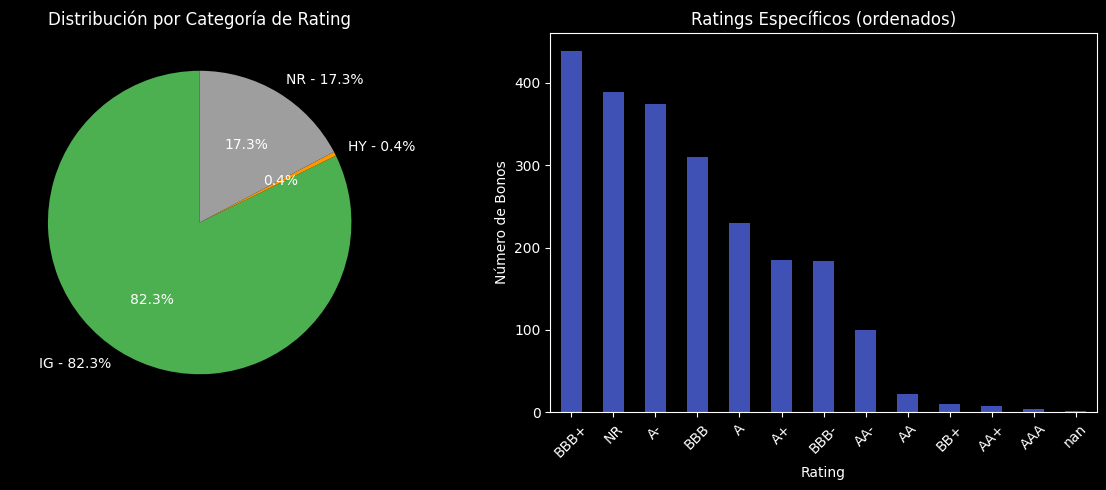

In [8]:
## Aquí tengo dudas. !!!Repasar , porque no sé si son las distintas agencias dan un raiting distinto, pero que luego se llama igual, o está todo rateado por la misma agencia?

print("ANÁLISIS DE RATINGS:")

rating_order = [
    'AAA+', 'AAA', 'AAA-', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-',
    'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-',
    'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D', 'NR'
]

# Distribución de ratings
print("\n• Distribución de Ratings Específicos:")
rating_dist = universo['Rating'].value_counts(dropna = False) 
#rating_dist = rating_dist.reindex(rating_order).dropna()
for rating, quantity in rating_dist.items():
    print(f"  - {rating}: {int(quantity)} bonos")


print("\n• Resumen:")

rating_category_map = {}
for rating in rating_order:
    if rating == 'NR':
        rating_category_map[rating] = 'NR'
    elif rating_order.index(rating) <= rating_order.index('BBB-'):
        rating_category_map[rating] = 'IG'
    else:
        rating_category_map[rating] = 'HY'

# Mapear categorías desde rating_dist
category_counts = {'IG': 0, 'HY': 0, 'NR': 0}
for rating, count in rating_dist.items():
    categoria = rating_category_map.get(rating, 'NR')
    category_counts[categoria] += count

# Mostrar resumen
total_bonos = rating_dist.sum()

for cat in ['IG', 'HY', 'NR']:
    count = category_counts[cat]
    pct = count / total_bonos * 100
    print(f"  • {cat}: {int(count)} bonos ({pct:.1f}%)")

print("\n")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart de categorías (IG, HY, NR)
category = ['IG', 'HY', 'NR']
porcentajes = [category_counts[cat] / total_bonos * 100 for cat in category]
axes[0].pie(
    porcentajes,
    labels=[f'{cat} - {pct:.1f}%' for cat, pct in zip(category, porcentajes)],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#4CAF50', '#FF9800', '#9E9E9E']
)
axes[0].set_title('Distribución por Categoría de Rating')
axes[0].set_ylabel('')

# Bar chart de ratings específicos ordenados
rating_dist.plot(kind='bar', ax=axes[1], color='#3F51B5')
axes[1].set_title('Ratings Específicos (ordenados)')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Número de Bonos')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Conclusión:** Hay un bono que tiene valor rating #N/A N/A. Consideramos que se trata un error de los datos ya que si no tuviese rating sería NR.

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

In [9]:
print("\n• Riesgo de liquidez:")

hor = universo[universo['Ask Price'] - universo['Bid Price'] > 0.5]

print(f"Los bonos que tienen riesgo de liquidez son: {len(hor)}")
hor.head(5)


• Riesgo de liquidez:
Los bonos que tienen riesgo de liquidez son: 325


,ISIN,Description,Ccy,Price,Issuer,Industry Sector,Maturity,Coupon,Rating,PD 1YR,...,Callable,Next Call Date,Seniority,Coupon Frequency,Coupon Type,First Coupon Date,Penultimate Coupon Date,Issue date,Bid Price,Ask Price
0,XS0161488498,DT 7 ½ 01/24/33,EUR,127.8353,DEUTSCHE TELEKOM INT FIN,Communications,24/01/2033,7.500,BBB+,0.021966,...,N,NaN,Sr Unsecured,1,FIXED,24/01/2004,24/01/2032,24/01/2003,127.462,128.208
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,EUR,131.3195,ORANGE SA,Communications,28/01/2033,8.125,BBB+,0.000021,...,N,NaN,Sr Unsecured,1,FIXED,28/01/2004,28/01/2032,28/01/2003,130.991,131.648
2,XS0162513211,EOANGR 5 ¾ 02/14/33,EUR,115.7800,E.ON INTL FINANCE BV,Utilities,14/02/2033,5.750,BBB+,0.000101,...,N,NaN,Sr Unsecured,1,FIXED,14/02/2004,14/02/2032,14/02/2003,115.447,116.114
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,EUR,116.3000,TELEFONICA EUROPE BV,Communications,14/02/2033,5.875,BBB-,0.000125,...,N,NaN,Sr Unsecured,1,FIXED,14/02/2004,14/02/2032,14/02/2003,115.984,116.616
4,FR0010014845,PEUGOT 6 09/19/33,EUR,112.3887,PSA TRESORERIE GIE,"Consumer, Cyclical",19/09/2033,6.000,BBB,0.024240,...,N,NaN,Sr Unsecured,1,FIXED,19/09/2004,19/09/2032,19/09/2003,111.839,112.938


In [10]:
print("\n• Nominal vivo (Outstanding Amount):")
print("\n Los bonos con mayor nominal vivo suelen tener más negociación. Top 5: ")
oa = universo[["ISIN", "Issuer", "Outstanding Amount"]].sort_values(by="Outstanding Amount", ascending=False)
oa.head(5)


• Nominal vivo (Outstanding Amount):

 Los bonos con mayor nominal vivo suelen tener más negociación. Top 5: 


,ISIN,Issuer,Outstanding Amount
1720,CH1214797172,UBS GROUP AG,3000000000
189,XS1586555945,VOLKSWAGEN INTL FIN NV,2500000000
1492,XS2461234622,JPMORGAN CHASE & CO,2500000000
1892,XS2595028536,MORGAN STANLEY,2000000000
109,XS1463043973,WELLS FARGO & COMPANY,2000000000


In [11]:
print("\n Top 5 bonos con menor nominal vivo: ")
oa.tail(5)


 Top 5 bonos con menor nominal vivo: 


,ISIN,Issuer,Outstanding Amount
1684,FR001400CSY7,COFACE SA,300000000
2171,XS2700245561,RAIFFEISEN BANK SA ROMAN,300000000
317,FR0013321536,CARMILA SA,274300000
887,XS2203802462,NE PROPERTY BV,250003000
608,XS2063535970,NE PROPERTY BV,249997000


#### <font color=#808080>Resto de información</font>

Otro datos que consideramos que se pueden analizar son PD 1YR.

In [12]:
pd_1y = universo[['ISIN', 'Issuer', 'Rating', 'PD 1YR']]

pd_1y.sort_values(by="PD 1YR", ascending=False).head()

,ISIN,Issuer,Rating,PD 1YR
818,XS2177021602,LINDE FINANCE BV,A,0.063122
817,XS2177021271,LINDE FINANCE BV,A,0.063122
84,XS1397134609,LINDE FINANCE BV,A,0.063122
98,XS1405784015,KRAFT HEINZ FOODS CO,BBB,0.058569
520,XS2022084367,CNH INDUSTRIAL FIN EUR S,BBB,0.054470


Destacamos que en el top cinco de bonos con mayor probabilidad de impago a un año, no aparece ninguno que no tenga rating.

In [13]:
nr_pd_1y = universo[universo['Rating'] == 'NR'][['ISIN', 'Issuer', 'Rating', 'PD 1YR']]
nr_pd_1y.sort_values(by="PD 1YR", ascending=False).head()

,ISIN,Issuer,Rating,PD 1YR
2077,FR001400J861,TDF INFRASTRUCTURE SAS,NR,0.031020
1389,FR0014006TQ7,TDF INFRASTRUCTURE SAS,NR,0.031020
1511,XS2441247041,NOVO NORDISK FINANCE NL,NR,0.030358
1513,XS2449330179,NOVO NORDISK FINANCE NL,NR,0.030358
2201,XS2720896047,LEASYS SPA,NR,0.025047


In [14]:
universo.isna().sum()

ISIN                         0
Description                  0
Ccy                          0
Price                        0
Issuer                       0
Industry Sector              0
Maturity                    19
Coupon                       0
Rating                       1
PD 1YR                      24
Outstanding Amount           0
Callable                     0
Next Call Date             615
Seniority                    0
Coupon Frequency             0
Coupon Type                  0
First Coupon Date            0
Penultimate Coupon Date     19
Issue date                   0
Bid Price                    0
Ask Price                    0
dtype: int64

**GAPs de información:** 
Podemos ver que hay 19 bonos que no tienen Maturity ni Penultimate Coupon Date, son bonos perpetuos.
Hay 24 bonos que no tiene PD 1YR, no tenemos esa información. 
También podemos comprobar que de los 615 bonos que no tienen Next Call Date ninguno es callable.
Hay un bono que no tiene rating. Dada su baja probabilidad, 0,000436, estaría en un rating AAA+. Sin embargo, consideramos que no es bono válido. 

In [15]:
len(universo[universo['Next Call Date'].isna() & universo['Callable'] == 'Y']['ISIN'])

0

In [16]:

# Función para limpiar columnas numéricas
def clean_numeric_column(col):
    """Limpia columnas numéricas reemplazando valores no válidos"""
    if col.dtype == object:
        # Reemplazar comas por puntos como separador decimal si es necesario
        col = col.astype(str).str.replace(',', '.')
        # Reemplazar cadenas de texto comunes por NaN
        col = col.replace(['#N/D', '#N/A', 'N/A'], np.nan)
        # Convertir a numérico, forzando los errores a NaN
        col = pd.to_numeric(col, errors='coerce')
    return col

# Fecha de análisis
fecha_analisis = pd.to_datetime('2025-10-01')
print(f"Fecha de análisis: {fecha_analisis.strftime('%Y-%m-%d')}")


# Limpiar columnas numéricas
numeric_columns = ['Price', 'Coupon', 'PD 1YR', 'Outstanding Amount',
                   'Coupon Frequency', 'Bid Price', 'Ask Price']
for col in numeric_columns:
    if col in universo.columns:
        universo[col] = clean_numeric_column(universo[col])

# Convertir fechas
date_columns = ['Maturity', 'Next Call Date', 'First Coupon Date',
                'Penultimate Coupon Date', 'Issue date']
for columna in date_columns:
    if columna in universo.columns:
        universo[columna] = pd.to_datetime(universo[columna], format='%d/%m/%Y', errors='coerce')

# Calcular años hasta vencimiento
universo['years_to_maturity'] = (universo['Maturity'] - fecha_analisis).dt.days / 365.25

print(f"\n nº fondos: {len(universo)} bonos")
print(" Información general del universo:")
print(universo.head())

universo.info()

Fecha de análisis: 2025-10-01

 nº fondos: 2255 bonos
 Información general del universo:
           ISIN          Description  Ccy     Price                    Issuer  \
0  XS0161488498      DT 7 ½ 01/24/33  EUR  127.8353  DEUTSCHE TELEKOM INT FIN   
1  FR0000471930   ORAFP 8 ⅛ 01/28/33  EUR  131.3195                 ORANGE SA   
2  XS0162513211  EOANGR 5 ¾ 02/14/33  EUR  115.7800      E.ON INTL FINANCE BV   
3  XS0162869076  TELEFO 5 ⅞ 02/14/33  EUR  116.3000      TELEFONICA EUROPE BV   
4  FR0010014845    PEUGOT 6 09/19/33  EUR  112.3887        PSA TRESORERIE GIE   

      Industry Sector   Maturity  Coupon Rating    PD 1YR  ...  \
0      Communications 2033-01-24   7.500   BBB+  0.021966  ...   
1      Communications 2033-01-28   8.125   BBB+  0.000021  ...   
2           Utilities 2033-02-14   5.750   BBB+  0.000101  ...   
3      Communications 2033-02-14   5.875   BBB-  0.000125  ...   
4  Consumer, Cyclical 2033-09-19   6.000    BBB  0.024240  ...   

   Next Call Date     Senio

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

In [17]:
precios_hist_universo_path = Path('../data/precios_historicos_universo.csv')
precios_historicos_universo = pd.read_csv(precios_hist_universo_path, sep=';', encoding='utf-8-sig', header=None)

/var/folders/k4/y7yhj5h91ws_nh7yxjg8p32w0000gn/T/ipykernel_37023/225044474.py:2: DtypeWarning: Columns (2,3,4,5,6,9,10,11,12,13,16,17,18,19,20,23,24,25,26,27,30,31,32,33,34,37,38,39,40,41,44,45,46,47,48,51,52,53,54,55,58,59,60,61,62,65,66,67,68,69,72,73,74,75,76,79,80,81,82,83,88,89,90,94,95,96,97,100,101,102,103,104,107,108,109,110,111,114,115,116,117,118,121,122,123,124,125,128,129,130,131,132,135,136,137,138,139,142,143,144,145,146,149,150,151,152,153,156,157,158,159,160,163,164,165,166,167,170,171,172,173,174,177,178,179,180,185,186,187,188,191,192,193,194,195,198,199,200,201,202,205,206,207,208,209,212,213,215,216,219,220,221,222,223,226,227,228,229,230,233,234,235,236,237,240,241,242,243,244,247,248,249,250,251,254,255,256,257,258,261,262,263,264,265,268,269,270,271,272,275,276,277,278,279,282,283,284,285,286,289,290,291,292,293,296,297,298,299,300,303,304,305,306,307,310,311,312,313,314,317,318,319,320,321,324,325,326,327,328,331,332,333,334,335,338,339,340,341,342,345,346,347,3

In [18]:
precios = precios_historicos_universo.drop(precios_historicos_universo.columns[1], axis=1)

Se elimina la columna con fecha, 2023-10-02, ya que es domingo y no se tiene datos anteriores.

In [19]:
precios.iloc[0,0] = 'ISIN'
fechas = precios.iloc[0, 1:]
columna_isin = precios.iloc[1:, 0]

In [20]:
precios_nd = precios.iloc[1:,1:].copy()
precios_nd.replace('#N/D', pd.NA, inplace = True)
precios_nan = precios_nd.apply(pd.to_numeric, errors='coerce')

precios_ffill = precios_nan.ffill(axis=1)

Se sustituye #N/D por NaN, y se rellenan los datos con los precios del dia anterior en caso de que sea fin de semana. 

In [21]:
fila_fechas = pd.DataFrame([['ISIN'] + list(fechas)], columns=precios.columns)
data = pd.concat([columna_isin.reset_index(drop=True), precios_ffill.reset_index(drop=True)], axis=1)
data.columns = precios.columns

In [22]:
final_precios_hist_univ = pd.concat([fila_fechas, data], ignore_index=True)

##### <font color=#CC6600>Otros precios</font>

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

In [23]:
precios_hist_varios_path = Path('../data/precios_historicos_varios.csv')
precios_historicos_varios = pd.read_csv(precios_hist_varios_path, sep=';', encoding='utf-8-sig')

In [24]:
precios_historicos_varios.columns.values[0] = 'Fecha'
precios_historicos_varios.head()

,Fecha,ITRX EUR CDSI GEN 5Y Corp,ITRX XOVER CDSI GEN 5Y Corp,DU1 Comdty,OE1 Comdty,RX1 Comdty,RECMTREU Index
0,02/10/2023,82.44325,439.1052,104.93,115.43,127.75,149.0285
1,03/10/2023,86.04738,455.2537,104.965,115.33,127.28,148.8003
2,04/10/2023,85.58153,453.8545,104.99,115.35,127.37,148.5200
3,05/10/2023,87.82574,461.1187,105.095,115.73,128.07,148.8967
4,06/10/2023,85.57082,453.675,105.105,115.72,127.94,148.7697


En el archivo de precios_historicos_varios, se encuentra los datos de cinco indices con el rango de fechas hasta 2023-10-02. Los indices son:  
* ITRX EUR CDSI GEN 5Y Corp,  iTraxx Europe Main 5Y:  representa un índice de Credit Default Swaps (CDS) sobre 125 empresas europeas con calificación de crédito investment grade, con horizonte en 5 años. 
* ITRX XOVER CDSI GEN 5Y Corp: Índice de Credit Default Swaps (CDS) con horizonte en 5 años, 75 empresas europeas con calificación por debajo de grado de inversión, high yield.
* DU1 Comdty, Euro-Bund Futures: su subyacente es el bono del gobierno alemán con vencimiento a 10 años.
* OE1 Comdty, Euro-OAT Futures: su subyacente es el bono del gobierno francés y con vencimiento a 5 años.
* RX1 Comdty, Euro-Buxl Futures: su subyacente es el bono del gobierno aleman con vencimiente de 24 1a 35 años. 
* RECMTREU Index, Bloomberg MSCI Euro Corporate SRI Total Return Index Unhedged: Indice de renta fija corporativa.

In [25]:
curva_estr_path = Path('../data/curvaESTR.csv')
curva_estr = pd.read_csv(curva_estr_path, sep=';', encoding='utf-8-sig')

In [26]:
#curva_estr = curva_estr.drop(index=0)


In [27]:
curva_estr.head(10)

,Date,Market Rate,Zero Rate,Discount
0,01/10/2025,NaN,NaN,1.000000
1,10/10/2025,1.92700,1.95350,0.999518
2,17/10/2025,1.92800,1.95402,0.999144
3,03/11/2025,1.92800,1.95320,0.998236
4,03/12/2025,1.92900,1.95264,0.996635
5,05/01/2026,1.92710,1.94907,0.994887
6,03/02/2026,1.92745,1.94523,0.993360
7,03/03/2026,1.92210,1.94115,0.991896
8,07/04/2026,1.91720,1.93447,0.990086
9,04/05/2026,1.91180,1.92772,0.988709


In [28]:
#Convertir fechas a días desde hoy
curva_estr['Date'] = pd.to_datetime(curva_estr['Date'], dayfirst=True) #columna Date en formato datetime
fecha_valor = pd.to_datetime('10/10/2025', dayfirst=True) #define la fecha de valoración
curva_estr['Days'] = (curva_estr['Date'] - fecha_valor).dt.days #Calcula los dias desde la fecha de valoracion
curva_estr['YearFrac'] = curva_estr['Days'] / 365  #Calcula la fraccion de año con base ACT/365

#- Valorar instrumentos descontando flujos con Discount = exp(-ZeroRate × YearFrac) si necesitas recalcular.


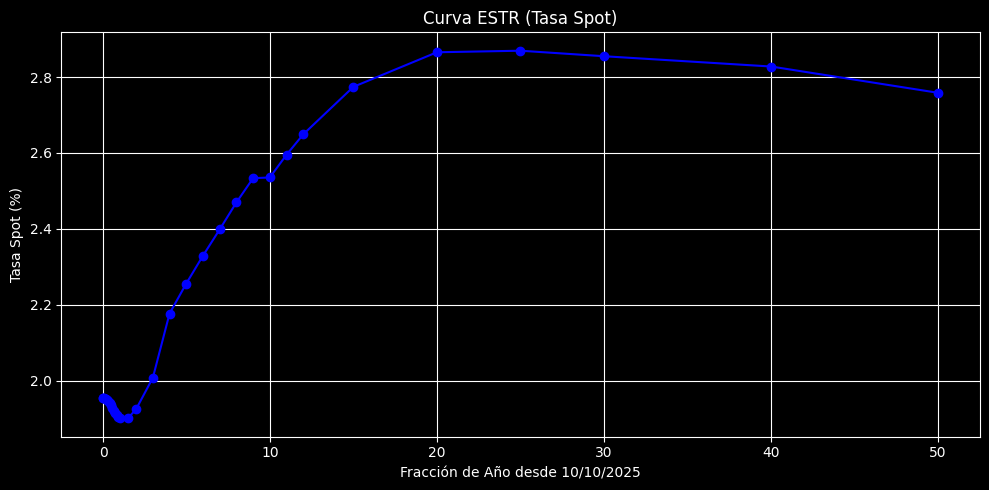

In [29]:
#La columna Zero Rate = Tasa Spot

plt.figure(figsize=(10, 5))
plt.plot(curva_estr['YearFrac'], curva_estr['Zero Rate'], marker='o', linestyle='-', color='blue')
plt.title('Curva ESTR (Tasa Spot)')
plt.xlabel('Fracción de Año desde 10/10/2025')
plt.ylabel('Tasa Spot (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


### <font color=#336699>2. Valoración</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
- ¿Qué observas si comparas los precios obtenidos y los precios de mercado?
- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
- ¿Qué otros factores influyen en ese spread?

Para la valoración, haz las siguientes simplificaciones:

- Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
- Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
- Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
- Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

</div>

In [30]:
# Establecemos la fecha
fecha_valor = datetime.datetime(2025,10,1)

In [31]:
import simulation

curva = simulation.read_curve('curvaESTR.csv')
# Calcular los precios "justos"
universo_evaluado = simulation.evaluate_bonds(fecha_valor, universo, curva, 0)
universo_evaluado[universo_evaluado['Price'] < universo_evaluado['Clean Price']].head()


,ISIN,Description,Ccy,Price,Issuer,Industry Sector,Maturity,Coupon,Rating,PD 1YR,...,Coupon Type,First Coupon Date,Penultimate Coupon Date,Issue date,Bid Price,Ask Price,years_to_maturity,Clean Price,Dirty Price,Accrued Interest
0,XS0161488498,DT 7 ½ 01/24/33,EUR,127.8353,DEUTSCHE TELEKOM INT FIN,Communications,2033-01-24,7.500,BBB+,0.021966,...,FIXED,2004-01-24,2032-01-24,2003-01-24,127.462,128.208,7.315537,148.690150,169.532862,20.842712
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,EUR,131.3195,ORANGE SA,Communications,2033-01-28,8.125,BBB+,0.000021,...,FIXED,2004-01-28,2032-01-28,2003-01-28,130.991,131.648,7.326489,157.390538,179.447249,22.056710
2,XS0162513211,EOANGR 5 ¾ 02/14/33,EUR,115.7800,E.ON INTL FINANCE BV,Utilities,2033-02-14,5.750,BBB+,0.000101,...,FIXED,2004-02-14,2032-02-14,2003-02-14,115.447,116.114,7.373032,128.909972,140.119774,11.209803
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,EUR,116.3000,TELEFONICA EUROPE BV,Communications,2033-02-14,5.875,BBB-,0.000125,...,FIXED,2004-02-14,2032-02-14,2003-02-14,115.984,116.616,7.373032,130.190039,141.694973,11.504935
4,FR0010014845,PEUGOT 6 09/19/33,EUR,112.3887,PSA TRESORERIE GIE,"Consumer, Cyclical",2033-09-19,6.000,BBB,0.024240,...,FIXED,2004-09-19,2032-09-19,2003-09-19,111.839,112.938,7.967146,135.348062,135.577296,0.229235


A continuación se muestra una comparativa de los precios limpios estimados (los que ven en herramientas como Bloomberg) con los del mercado. Como los precios históricos cubren hasta el 01/10/2025, compararemos el precio que hemos calculado con fecha del 01/10/2025 con los precios históricos del mercado en ese mismo día.

In [32]:
precios_hist_universo_path = Path('../data/precios_historicos_universo.csv')
precios_historicos_universo = pd.read_csv(precios_hist_universo_path, sep=';', encoding='utf-8-sig', dtype='str')
precios_historicos_universo.head()
precios_historicos_universo = precios_historicos_universo.rename(columns={precios_historicos_universo.columns[0]: "ISIN"})
# Eliminamos 'CORP' del ISIN
precios_historicos_universo['ISIN'] = precios_historicos_universo['ISIN'].apply(lambda i: i.split(' ')[0])

columna_fecha_hoy = fecha_valor.strftime('%d/%m/%Y')
diferencia = pd.merge(universo_evaluado[['ISIN', 'Clean Price']], precios_historicos_universo[['ISIN', columna_fecha_hoy]], on='ISIN')
# Como hemos leido el csv como str, debemos pasar la columna de precios a float
diferencia[columna_fecha_hoy] = pd.to_numeric(diferencia[columna_fecha_hoy], errors='coerce')
diferencia['% Error'] = abs(diferencia[columna_fecha_hoy] - diferencia['Clean Price']) / diferencia[columna_fecha_hoy] * 100
diferencia.head(10)

,ISIN,Clean Price,01/10/2025,% Error
0,XS0161488498,148.690150,127.8353,16.313843
1,FR0000471930,157.390538,131.3195,19.853136
2,XS0162513211,128.909972,115.7800,11.340449
3,XS0162869076,130.190039,116.3000,11.943283
4,FR0010014845,135.348062,112.3887,20.428532
5,FR0010033381,110.587242,119.7020,7.614541
6,XS0229567440,116.694049,105.4562,10.656414
7,XS0300113254,102.700451,104.0970,1.341584
8,XS0350890470,157.414850,124.7700,26.164022
9,XS0553728709,59.092522,108.6433,45.608682


Al comparar los precios calculados con los de mercados vemos que los porcentajes de error son bastante elevados. Aunque también influye utilizar un spread = 0 en el cálculo, no es el único factor que causa esta diferencia; se deben tener en cuenta factores como la oferta/demanda de cada bono, el rating del issuer, nominal vivo, etc. Es decir, factores no contemplados que hacen más o menos atractivo invertir en un bono frente a otros.

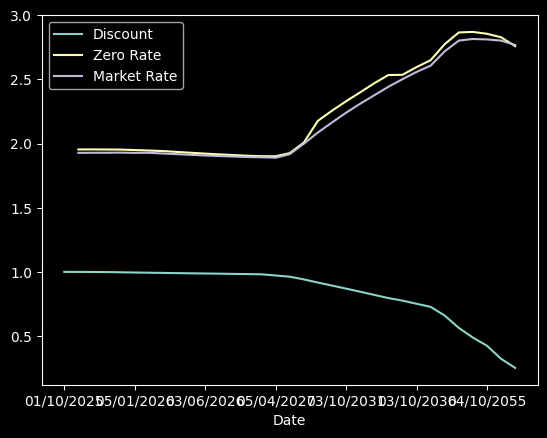

In [33]:
simulation.plot_curve(curva)

### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior.
- ¿Qué observas? ¿Tienen sentido los resultados?
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

##### <font color=#CC6600>Riesgo de crédito</font>

##### <font color=#CC6600>Riesgo de liquidez</font>

##### <font color=#CC6600>Backtest</font>

### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>